In [4]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset

import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
# https://www.kaggle.com/datasets/nimishmagre/tmnist-typeface-mnist
# Numbers 0-9 in different fonts
data = pd.read_csv('TMNIST_Data.csv')
data = data.drop(columns=['names'])

training_data = data[int(len(data)*.10):]
testing_data = data[:int(len(data)*.10)]

data

,labels,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29895,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29896,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29898,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
scaler = preprocessing.MinMaxScaler().fit(training_data.drop(columns=['labels']).to_numpy())

batch_size = 16

training_dataset = TensorDataset(torch.tensor(np.array([scaler.transform([i[1:]]).reshape([1,28,28]) for i in training_data.values]), dtype=torch.float64), torch.tensor(training_data['labels'].to_numpy()))
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.tensor(np.array([scaler.transform([i[1:]]).reshape([1,28,28]) for i in testing_data.values]), dtype=torch.float64), torch.tensor(testing_data['labels'].to_numpy()))
testing_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
def test(X, y, model, device, loss):
    out = model(X.to(device=device))
    
    return loss(out, y.to(device=device)), out
    
def train(X,y, model, device, loss, opt):
    out = model(X.to(device=device))
    l = loss(out, y.to(device=device))
    
    l.backward()
    opt.step()
    opt.zero_grad()
    
    return l

In [19]:
class classifier_output_10(nn.Module):
    def __init__(self):
        super(classifier_output_10, self).__init__()
        
        # Convolution
        self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, dtype=torch.float64)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.2)
        
        # Fully Connected Layer
        self.sigmoid = nn.Sigmoid()
        self.l1 = nn.Linear(1728, 500, dtype=torch.float64)
        self.l2 = nn.Linear(500,10, dtype=torch.float64)
    def forward(self, x):
        # Convolution
        x = self.drop(self.conv(x))
        
        # Pooling
        x = self.pool(x)
        x = self.relu(x)        
        x = torch.flatten(x, 1)
        
        # Fully Connected Layer

        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.l2(x)
        x = self.sigmoid(x)
        
        return x
    
class classifier_output_2(classifier_output_10):
    def __init__(self):
        super(classifier_output_2, self).__init__()
    def forward(self, x):
        # Convolution
        x = self.conv(x)
        
        # Pooling
        x = self.pool(x)
        x = self.relu(x)        
        x = torch.flatten(x, 1)
        
        # Fully Connected Layer

        x = self.l1(x)
        return x

In [37]:
if __name__ == "__main__":
    device = torch.device("cuda:0")
    model = classifier_output_10().to(device=device)
    loss = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.005)
    epochs = 10
    
    training_losses = []
    testing_losses = []
    
    final_out = []
    final_y = []
    
    for e in range(epochs):
        # Train model
        training_loss = 0
        for X, y in training_dataloader:
            
            l = train(X, y, model, device, loss, opt)
            
            training_loss += l.detach().cpu().item()
        # Test model
        testing_loss = 0
        for X, y in testing_dataloader:

            l, out = test(X, y, model, device, loss)
            
            testing_loss += l.detach().cpu().item()

            # Put final test output in dataframe 
            if (e == epochs-1):
                final_out.extend([torch.argmax(i).item() for i in out])
                final_y.extend(y.flatten().detach().numpy())
        
        training_loss /= len(training_data)
        training_losses.append(training_loss)
        testing_loss /= len(testing_data)
        testing_losses.append(testing_loss)
        
        print(f"Epoch {e+1}/{epochs}:")
        print("Training loss = ", training_loss)
        print("Testing loss = ", testing_loss)
        
torch.save(model.state_dict(), 'model1.pt')

output = pd.DataFrame({'Expected Temperature': final_y,
               'Predicted Temperature': final_out})        
output.to_csv("out.csv")

Epoch 1/10:
Training loss =  0.09470766392396339
Testing loss =  0.8320228401231877
Epoch 2/10:
Training loss =  0.0924816675541234
Testing loss =  0.8353902019636901
Epoch 3/10:
Training loss =  0.09230316535497193
Testing loss =  0.8304616881269248
Epoch 4/10:
Training loss =  0.09223520794342842
Testing loss =  0.8311290911395516
Epoch 5/10:
Training loss =  0.09212230388476696
Testing loss =  0.8285952705904019
Epoch 6/10:
Training loss =  0.09211021125978838
Testing loss =  0.8277136143944254
Epoch 7/10:
Training loss =  0.09208412712892691
Testing loss =  0.8274415915965395
Epoch 8/10:
Training loss =  0.09204220481506362
Testing loss =  0.8270112023573303
Epoch 9/10:
Training loss =  0.09201064583489386
Testing loss =  0.8264310909304337
Epoch 10/10:
Training loss =  0.09202887102441036
Testing loss =  0.8272580208574368


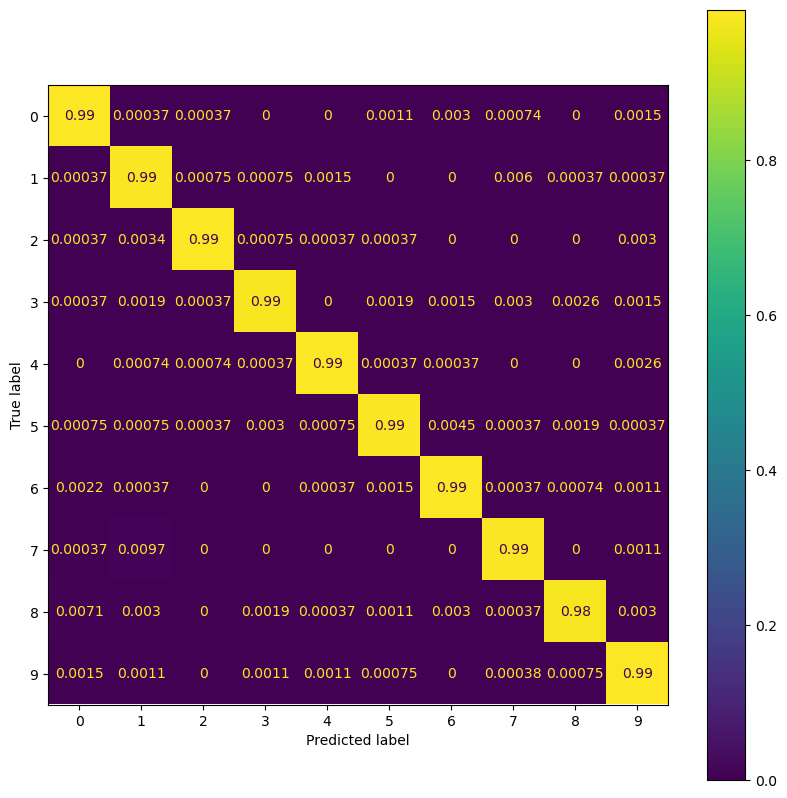

In [38]:
cf = confusion_matrix(final_y, final_out, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=range(0,10))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

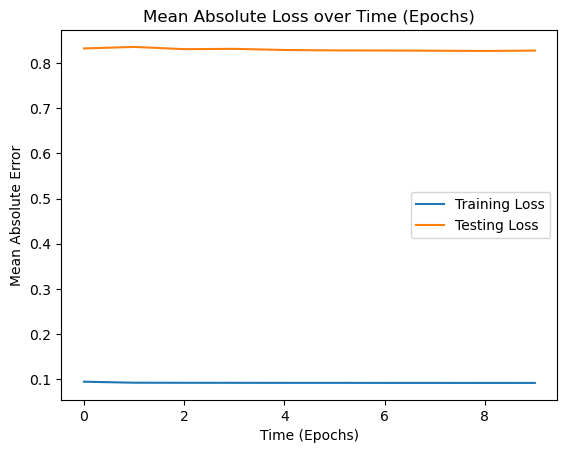

In [39]:
plt.plot(np.arange(epochs), [x for x in training_losses], label="Training Loss")
plt.plot(np.arange(epochs), [x for x in testing_losses], label="Testing Loss")

plt.title(f'Mean Absolute Loss over Time (Epochs)')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Time (Epochs)')

plt.legend()
plt.show()

In [40]:
model = classifier_output_2()
model.load_state_dict(torch.load('model.pt'))
model.eval()

out = []
y_vals = []

for X, y in testing_dataloader:
    out.extend(model(X).tolist())
    y_vals.extend(y.tolist())


tsne = TSNE(n_components=2, n_iter=1000)
tsne_result = tsne.fit_transform(np.array(out))

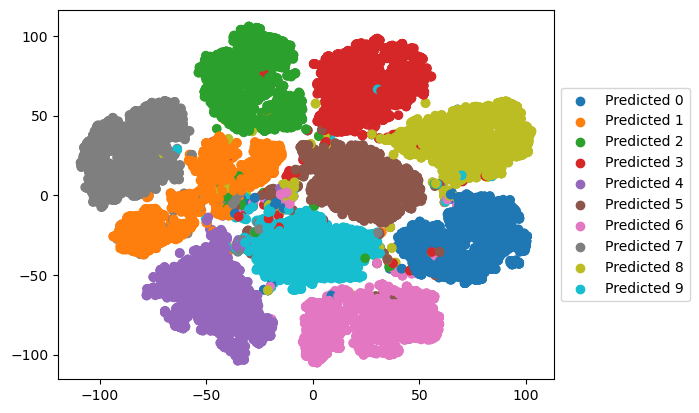

In [41]:
unique = np.unique(y_vals)

cmap = mpl.colormaps.get_cmap('tab10')

plt.scatter(*zip(*tsne_result), c=y_vals, cmap=cmap)

for i, label in enumerate(unique):
    plt.scatter([], [], color=cmap(i), label=f'Predicted {label}')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()